In [61]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install matplotlib
!pip install sentencepiece
!pip install transformers>=4.8.2
!pip install numpy==1.23.1
!pip install torch>=1.8.1
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-f5fed5if/kobert-tokenizer_26c027114ca044a19016a6b0598e1912
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-f5fed5if/kobert-tokenizer_26c027114ca044a19016a6b0598e1912
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [62]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import numpy as np
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [81]:
device = torch.device("cuda:0")

In [82]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [83]:
import pandas as pd
data = pd.read_csv('Startup_Ideas.csv')

In [84]:
datalabel = data.loc[:, ['Technology','Healthcare & Wellness','Education','Environment & Sustainability','Media & Entertainment','Culture & Arts','Finance & Business','Social Impact & Public Good','Consumer Products & Services','Transportation & Logistics']]

data_list = data.apply(lambda row: [row['Idea'], row[1:].tolist()], axis=1)

print(data_list[1])

['기후 변화에 대응하는 물류 솔루션 비용 증가를 해결하기 위해 AR 기술을 활용', [1, 0, 0, 0, 0, 0, 0, 0, 0, 1]]


In [85]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.15, random_state=42)

print(len(dataset_train))
print(len(dataset_test))

2068
366


In [86]:
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [87]:
class BERTDataset(Dataset):
    def __init__(self, dataset, bert_tokenizer, vocab, max_len, pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length = max_len, vocab = vocab, pad=pad, pair=pair)

        self.sentences = [transform([txt[0]]) for txt in dataset]
        self.labels = torch.tensor([label[1] for label in dataset]).to(device)

    def __getitem__(self,i):
        return (self.sentences[i] + (self.labels[i],))

    def __len__(self):
        return(len(self.labels))

In [88]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
learning_rate =  5e-5

In [89]:
data_train = BERTDataset(dataset_train, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, tokenizer, vocab, max_len, True, False)

In [90]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=0)

In [91]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size = 768, num_classes=10, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [92]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [93]:
from sklearn.metrics import accuracy_score

def accuracy(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred > 0.5, dtype=float)
    y_pred=y_pred.T
    y_true=y_true.T
    acc_list=[]
    for cate in range(0,y_pred.shape[0]):
        acc_list.append(accuracy_score(y_pred[cate],y_true[cate]))
    return sum(acc_list)/len(acc_list)

In [94]:
train_history = []
test_history = []
loss_history = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.float().to(device)
        out = model(token_ids, valid_length, segment_ids)

        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

        train_acc = accuracy(label.cpu().detach().numpy(), nn.Sigmoid()(out).cpu().detach().numpy())

        print("[train] epoch {} batch id {} loss {} acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc))
        train_history.append(train_acc)
        loss_history.append(loss.data.cpu().numpy())

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc = accuracy(label.cpu().detach().numpy(), out.cpu().detach().numpy())

        print("[test] epoch {} acc {}".format(e+1, test_acc))
        test_history.append(test_acc)

[train] epoch 1 batch id 1 loss 0.67884761095047 acc 0.575
[train] epoch 1 batch id 2 loss 0.6757463812828064 acc 0.603125
[train] epoch 1 batch id 3 loss 0.6743188500404358 acc 0.578125
[train] epoch 1 batch id 4 loss 0.6714887619018555 acc 0.578125
[train] epoch 1 batch id 5 loss 0.6680645942687988 acc 0.5953125
[train] epoch 1 batch id 6 loss 0.6662351489067078 acc 0.5828125
[train] epoch 1 batch id 7 loss 0.6545540690422058 acc 0.5984375
[train] epoch 1 batch id 8 loss 0.6507363319396973 acc 0.634375
[train] epoch 1 batch id 9 loss 0.6454238891601562 acc 0.6515625
[train] epoch 1 batch id 10 loss 0.6370724439620972 acc 0.6546875
[train] epoch 1 batch id 11 loss 0.6256951689720154 acc 0.6765625
[train] epoch 1 batch id 12 loss 0.6210633516311646 acc 0.6953125
[train] epoch 1 batch id 13 loss 0.6159133315086365 acc 0.7015625
[train] epoch 1 batch id 14 loss 0.6115474700927734 acc 0.7015625
[train] epoch 1 batch id 15 loss 0.5889731049537659 acc 0.7390625
[train] epoch 1 batch id 16 l

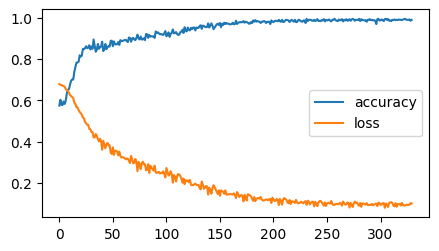

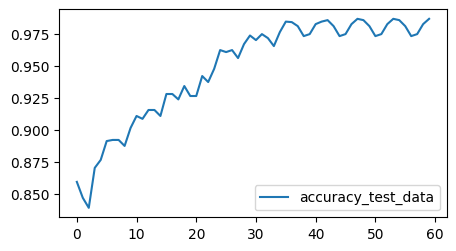

In [95]:
import matplotlib.pyplot as plt

#train graph
fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(np.arange(len(train_history)), train_history, label='accuracy')
ax.plot(np.arange(len(loss_history)), loss_history, label='loss')
ax.legend()

#test graph
fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(np.arange(len(test_history)), test_history, label='accuracy_test_data')
ax.legend()

In [101]:
torch.save(model, 'KoBERTag.pt')

In [96]:
def predict(predict_sentence):
    data = [predict_sentence, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 0)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        sigmoid = nn.Sigmoid()

        out = model(token_ids, valid_length, segment_ids)
        out = sigmoid(out)

        test_eval = []
        for logits in out.cpu().detach().numpy()[0]:
            test_eval.append(int(logits > 0.5))

        result = []
        label = ['Technology','Healthcare & Wellness','Education','Environment & Sustainability','Media & Entertainment','Culture & Arts','Finance & Business','Social Impact & Public Good','Consumer Products & Services','Transportation & Logistics']

        for i in range(len(label)):
          if test_eval[i] == 1:
            result.append(label[i])
            print('#' + label[i])

        if len(result) == 0:
          print('#other ')

        return test_eval

In [105]:
while (True):
  sentence = input("문장을 입력해주세요 : ")
  predict(sentence)

문장을 입력해주세요 : 인공지능 챗봇을 이용한 헬스 케어 서비스
#Technology
#Healthcare & Wellness
문장을 입력해주세요 : 인공지능을 이용한 에너지 절약 시스템
#Technology
#Environment & Sustainability
문장을 입력해주세요 : 음악 추천 사이트
#Technology
#Culture & Arts
문장을 입력해주세요 : 수학 교육 플랫폼
#Technology
#Education


KeyboardInterrupt: Interrupted by user